In [1]:
import re
import random
import numpy as np
from tqdm import trange
from newspaper import Article

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, TensorDataset
 
from transformers.models import gpt2
from transformers import GPT2Config, GPT2LMHeadModel

import matplotlib.pyplot as plt
%matplotlib inline

## Define the RNNAttention Model

In [2]:
# define the config to be used
vocab_size = 38
tinyconf = GPT2Config(
  vocab_size=vocab_size,
  n_positions=1024,
  n_ctx=1024,
  n_embd=128,
  n_layer=12,
  n_head=8
)

In [3]:
# from previous experiment
text_lengths = [  50,   59,   69,   79,   89,   99,  109,  118,  128,  138,  148,
        158,  168,  177,  187,  197,  207,  217,  227,  236,  246,  256,
        266,  276,  286,  295,  305,  315,  325,  335,  345,  354,  364,
        374,  384,  394,  404,  414,  423,  433,  443,  453,  463,  473,
        482,  492,  502,  512,  522,  532,  541,  551,  561,  571,  581,
        591,  600,  610,  620,  630,  640,  650,  659,  669,  679,  689,
        699,  709,  719,  728,  738,  748,  758,  768,  778,  787,  797,
        807,  817,  827,  837,  846,  856,  866,  876,  886,  896,  905,
        915,  925,  935,  945,  955,  964,  974,  984,  994, 1004, 1014,
       1024]

from time import time

## Vanilla Torch GPT

In [232]:
# startiGPT2LMHeadModelh GPT-2 from HF
model = GPT2LMHeadModel(tinyconf)
model.eval()
print("Num params:", model.num_parameters())

@torch.no_grad()
def generate(
  input_ids,
  max_length,
  num_return_sequences = 10
):
  # if just a sequence, batchify
  if len(input_ids.shape) == 1:
    input_ids = input_ids.unsqueeze(0)

  # since the hidden states for all `num_return_sequences` will be same
  # we first run those and then tile
  B, S = input_ids.shape

  assert B == 1, "Only 1 sequence at a time can be generated"
  
  input_ids = torch.tile(input_ids, [num_return_sequences, 1])
  
  for i in range(S+1, max_length+1, 1):
    logits = model(input_ids).logits[:, -1, :] # only the last token
    
    # sample next tokens randomly
    probs = F.softmax(logits, dim=-1)
    ix = torch.multinomial(probs, num_samples=1).view(-1, 1)
    input_ids = torch.cat([input_ids, ix], dim = -1)

Num params: 2515456


In [233]:
sample_inputs = torch.randint(low = 0, high = vocab_size, size = (1, 10))
time_per_seq_vanilla_gpt = {}
for _, max_length in zip(trange(len(text_lengths)), text_lengths):
  st = time()
  generate(sample_inputs, max_length)
  time_per_seq_vanilla_gpt[max_length] = time() - st

  2%|▏         | 2/100 [00:05<04:53,  3.00s/it]


KeyboardInterrupt: 

In [110]:
time_per_seq_vanilla_gpt.values()

dict_values([2.7556939125061035, 3.631237030029297, 5.041850805282593, 6.475341081619263, 7.973667144775391, 9.907263994216919, 12.24738597869873, 14.44433307647705, 17.759660959243774, 20.481817960739136, 23.869615077972412, 27.52582883834839, 31.847949981689453, 35.58147692680359, 41.39041876792908, 45.32008337974548, 50.932811975479126, 57.71962785720825, 63.91202187538147, 72.74398469924927, 77.16393685340881, 84.34650707244873, 92.53106188774109, 100.79639005661011, 110.76197385787964, 119.06515979766846, 129.40779399871826, 143.12383794784546, 146.09022688865662, 159.81267404556274, 173.79054307937622])

## ONNX runtime Transformer

In [7]:
# starting with GPT-2 from HF
model = GPT2LMHeadModel(tinyconf)
model.eval()
model.num_parameters()

2515456

In [8]:
# Export the model

# since this is a very large model we cannot export this as a single ONNX graph
# we pass argument use_external_data_format=True in torch.onnx.export(), last arg
# this creates a weight blob for different layers. we create a folder for this
# so everything is consolidated
import os
export_folder = "./data/gpt"
export_onnx = export_folder + "/model.onnx"
os.makedirs(export_folder, exist_ok=True)

# unlike our MNIST example where the dimensionality of input was fixed to 784
# BERT and transformer models can have 2D dynamic input/output
dynamic_axes_dict = {
  0:'batch_size',
  1:'sequence_length'
}

# eval mode and 
model.eval()

# since the input is fully dynamic, tiny sequence will work for trace
sample_input = torch.randint(low = 0, high = tinyconf.vocab_size, size = (1, 4))

# export model
torch.onnx.export(
  model = model,
  args = (
    sample_input,
  ),                         # model input (or a tuple for multiple inputs)
  f = export_onnx,           # where to save the model (can be a file or file-like object)
  export_params=True,        # store the trained parameter weights inside the model file
  opset_version=11,          # the ONNX version to export the model to
  do_constant_folding=True,  # whether to execute constant folding for optimization
  input_names = [
    'input_ids'
  ],                         # the model's input names
  output_names = ['logits'], # the model's output names
  dynamic_axes={
    'input_ids': dynamic_axes_dict,
    'logits': dynamic_axes_dict,
  },                         # variable length axes
)

/Users/yashbonde/Library/Python/3.8/lib/python/site-packages/transformers/models/gpt2/modeling_gpt2.py:170: TracerWarning: Converting a tensor to a Python float might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  w = w / (float(v.size(-1)) ** 0.5)


In [9]:
# check model: for models >2GB use onnx.checker
import onnx
onnx.checker.check_model(export_onnx)

# next run the model and see
import onnxruntime
ort_session = onnxruntime.InferenceSession(export_onnx)

In [15]:
# correct solution:
def softmax(x):
  """Compute softmax values for each sets of scores in x."""
  e_x = np.exp(x - np.max(x))
  return e_x / e_x.sum(axis=0) # only difference

In [81]:
def generate(
  input_ids,
  max_length,
  num_return_sequences = 10,
):
  # if just a sequence, batchify
  if len(input_ids.shape) == 1:
    input_ids = input_ids.reshape(1, *input_ids.shape)

  # since the hidden states for all `num_return_sequences` will be same
  # we first run those and then tile
  B, S = input_ids.shape

  assert B == 1, "Only 1 sequence at a time can be generated"
  
  input_ids = np.tile(input_ids, [num_return_sequences, 1])
  
  for i in range(S+1, max_length+1, 1):
    ort_inputs = {"input_ids": input_ids}
    logits = ort_session.run(None, ort_inputs)[0][:, -1, :] # only the last token
    
    # sample next tokens randomly
    new_tokens = np.asarray([np.random.multinomial(10, softmax(o)).argmax() for o in logits]).reshape(-1, 1)
    input_ids = np.hstack([input_ids, new_tokens])

In [88]:
sample_input = np.random.randint(low = 0, high = vocab_size, size = (10))
time_per_seq_onnx_gpt = {}
for _, max_length in zip(trange(len(text_lengths)), text_lengths):
  st = time()
  generate(sample_input, max_length)
  time_per_seq_onnx_gpt[max_length] = time() - st

 45%|████▌     | 45/100 [32:04<39:12, 42.78s/it]   


KeyboardInterrupt: 

## ONNX runtime TransRNN

In [4]:
# define the model from last notebook
class RNNAttention(nn.Module):
  # this is at the heart of T2R framework
  def __init__(self, config):
    super().__init__()
    self.config = config
    nx = config.n_embd
    head_size = config.n_embd // config.n_head
    nx_rnn = head_size
    
    self.c_attn = gpt2.modeling_gpt2.Conv1D(3 * nx, nx)
    self.c_proj = gpt2.modeling_gpt2.Conv1D(nx, nx)
    self.phi = nn.Sequential(
      nn.Linear(head_size, nx_rnn),
      nn.ReLU()
    )
    self.infer_ready = False

  def infer_init(self):
    """this function performs the merging of weights + refining the graph"""
    config = self.config
    
    # we get the matrices for the three qkv's by splitting the weights
    # since we anyways split the output of qkv into q,k,v the weight and bias
    # matrix can also be split
    wq, wk, wv = self.c_attn.weight.data.split(self.config.n_embd, dim = 1)
    bq, bk, bv = self.c_attn.bias.data.split(self.config.n_embd, dim = 0)
    
    # get the matrices for phi
    wp = self.phi[0].weight.data # [n_embd // n_head, nx_rnn]
    bp = self.phi[0].bias.data # [1, nx_rnn]
    
    
    # in GPT-2 coded from HF that we are using, the input state is projected
    # to 3 dimensions and then split to head q,k,v. This q,k,v is then split
    # into "d" parts (# of heads). This "d" heads are then passed through the
    # phi layer. Now when we try to fuse the weights, we hit wrong matrix
    # multiplication [E,E] * [Eh,Er] where:
    # * E:  config.n_embd
    # * Eh: config.n_embd // config.n_head
    # * Er: config.n_rnn (k-features from paper)
    # thus we tile the phi layer config.n_head times and then fuse
    wp = torch.tile(wp, [config.n_head, 1]) # [n_embd, nx_rnn]
    
    # We don't need to tile the biases because it will anyways be a vector
    # bp = torch.tile(bp, [config.n_head, 1])
    
    # cache the phi function weights and biases
    wpq = wq @ wp      # [n_embd, nx_rnn]
    bpq = bp + bq @ wp # [n_head, nx_rnn]
    wpk = wk @ wp
    bpk = bp + bk @ wp
    
    # define the phi layer functions
    self.v_layer = lambda x: x @ wv + bv
    self.phi_q = lambda x: torch.relu(x @ wpq + bpq)
    self.phi_k = lambda x: torch.relu(x @ wpk + bpk)
    
    # set flag that optimisation for inference is complete
    self.infer_ready = True
  
  def forward(self, x, s, z):
    assert self.infer_ready, "module not prepared for inference, run .prepare_infer()"
    
    # get q,k,v
    q = self.phi_q(x)
    k = self.phi_k(x)
    v = self.v_layer(x)
    
    # from previous state we get S and z for t-1
    s = s + k.permute((0, 2, 1)) @ v
    z = z + k
    
    # get output
    num = q @ s
    dem = q @ z.permute((0, 2, 1))
    out = num / dem
    
    return out, s, z
  
class Block(nn.Module):
  def __init__(self, config):
    super().__init__()
    
    inner_dim = config.n_inner if config.n_inner is not None else 4 * config.n_embd
    self.ln_1 = nn.LayerNorm(config.n_embd, eps=config.layer_norm_epsilon)
    self.attn = RNNAttention(config)
    # self.attn = gpt2.modeling_gpt2.Attention(config.n_embd, config.n_ctx, config)
    self.ln_2 = nn.LayerNorm(config.n_embd, eps=config.layer_norm_epsilon)
    self.mlp = gpt2.modeling_gpt2.MLP(inner_dim, config)
    
  def infer_init(self):
    self.attn.infer_init()
    
  def forward(self, hidden_states, s, z):
    attn_outputs, s, z = self.attn(self.ln_1(hidden_states), s, z)
    if isinstance(attn_outputs, tuple):
      attn_outputs = attn_outputs[0]
    # NOTE: this operation is not correct and will cause errors during loss.backward()
    # hidden_states += attn_outputs
    # because "+=" causes inplace update and not create a new variable meaning that
    # nodes from the graph will be missing.
    hidden_states = hidden_states + attn_outputs
    mlp_states = self.mlp(self.ln_2(hidden_states))
    hidden_states = hidden_states +  mlp_states
    return hidden_states, s, z
  
class T2RInfer(nn.Module):
  def __init__(self, config):
    super().__init__()
    
    self.wte = nn.Embedding(config.vocab_size, config.n_embd)
    self.wpe = nn.Embedding(config.n_positions, config.n_embd)
    self.drop = nn.Dropout(config.embd_pdrop)
    self.h = nn.ModuleList([Block(config) for _ in range(config.n_layer)])
    self.ln_f = nn.LayerNorm(config.n_embd, eps=config.layer_norm_epsilon)
    self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias = False)
    
    self.infer_ready = False # flag
    self.infer_init()
    
  def infer_init(self):
    print("Preparing Model for inference")
    for block in self.h:
      block.infer_init()
    self.infer_ready = True
    
  @staticmethod
  def top_k_logits(logits, k):
    v, ix = torch.topk(logits, k)
    out = logits.clone()
    out[out < v[:, [-1]]] = -1e10
    return out
  
  def forward(self, hstate, s, z):
    for block in self.h:
      # we don't need the outputs of the model for all these tokens only
      # the RNN states
      logits, s, z = block(hstate, s, z)
    logits = self.lm_head(self.ln_f(logits))
    return logits, s, z
  
  def get_next_tokens(self, logits, top_k, do_sample, num_return_sequences):
    if top_k is not None:
      logits = self.top_k_logits(logits, top_k)
    probs = F.softmax(logits, dim=-1)[:, -1, :]
    
    if do_sample:
      ix = torch.multinomial(probs, num_samples=num_return_sequences)
    else:
      _, ix = torch.topk(probs, k=num_return_sequences, dim=-1)
    
    return ix
     
  @torch.no_grad()
  def generate(
    self,
    input_ids,
    max_length,
    num_return_sequences = 1,
    top_k = None,
    do_sample = False
  ):
    assert self.infer_ready, "Not ready for inference. see `T2RInfer.infer_init()`"
    
    # if just a sequence, batchify
    if len(input_ids.shape) == 1:
      input_ids = input_ids.unsqueeze(0)
      
    # since the hidden states for all `num_return_sequences` will be same
    # we first run those and then tile
    B, S = input_ids.shape
    
    assert B == 1, "Only 1 sequence at a time can be generated"
    
    # we get position embeddings for max_length so we don't have to fetch
    # these values again and again for each step
    position_ids = torch.arange(0, max_length).long().unsqueeze(0)
    position_embeds = self.wpe(position_ids)
    inputs_embeds = self.wte(input_ids)

    # go over each token in the input sequence
    hidden_states = inputs_embeds + position_embeds[:, :S] # [B, S]
    s, z = [0,0] # initial state is always 0
    print(hidden_states.shape)
    for i in range(S):
      hstate = hidden_states[:, i].unsqueeze(1)
      logits, s, z = self.forward(hstate, s, z)

    # get the next tokens
    ix = self.get_next_tokens(logits, top_k, do_sample, num_return_sequences)
    generated_tokens = [ix[0]]

    # tile rnn state to handle more than one sequences
    if num_return_sequences > 1:
      input_ids = torch.tile(input_ids, [num_return_sequences, 1])
      s = torch.tile(s, [num_return_sequences, 1, 1])
      z = torch.tile(z, [num_return_sequences, 1, 1])
    
    for i in range(S, max_length - 1, 1):
      # for rest of the steps
      hidden_state = self.wte(generated_tokens[-1]) + position_embeds[:, i]
      hidden_state = hidden_state.unsqueeze(1)
      logits, s, z = self.forward(hidden_state, s, z)
      ix = self.get_next_tokens(logits, top_k, do_sample, num_return_sequences)
      generated_tokens.append(ix[0])
    
    generated_tokens = [x.unsqueeze(-1) for x in generated_tokens]
    generated_tokens = torch.cat(generated_tokens, dim = 1)
    full_seq = torch.cat([input_ids, generated_tokens], dim = 1)
    return full_seq

In [5]:
# test code:
attn = RNNAttention(tinyconf)
attn.infer_init()

# generate for 10 steps
B, E = 3, tinyconf.n_embd
s, z = [0, 0]
for _ in range(2):
  hidden_state, s, z = attn(torch.randn(3, 1, E), s, z)
  print(hidden_state.shape, s.shape, z.shape)

torch.Size([3, 1, 128]) torch.Size([3, 16, 128]) torch.Size([3, 1, 16])
torch.Size([3, 1, 128]) torch.Size([3, 16, 128]) torch.Size([3, 1, 16])


In [6]:
# let's test with full GPT-2

# vocab_size = 38
tinyconf = GPT2Config()

model = T2RInfer(tinyconf)
model = model.eval()
sum(p.numel() for p in model.parameters())

Preparing Model for inference


163087104

In [7]:
tinyconf

GPT2Config {
  "activation_function": "gelu_new",
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "gradient_checkpointing": false,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_inner": null,
  "n_layer": 12,
  "n_positions": 1024,
  "resid_pdrop": 0.1,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "transformers_version": "4.4.2",
  "use_cache": true,
  "vocab_size": 50257
}

In [8]:
tinyconf.n_embd // tinyconf.n_head

64

In [9]:
# Export the model

# since this is a very large model we cannot export this as a single ONNX graph
# we pass argument use_external_data_format=True in torch.onnx.export(), last arg
# this creates a weight blob for different layers. we create a folder for this
# so everything is consolidated
import os
export_folder = "./data/onnxrnn"
export_onnx = export_folder + "/model.onnx"
os.makedirs(export_folder, exist_ok=True)

# unlike our MNIST example where the dimensionality of input was fixed to 784
# BERT and transformer models can have 2D dynamic input/output
dynamic_axes_dict = {
  0:'batch_size',
}

# eval mode and 
model.eval()

# since the input is fully dynamic, tiny sequence will work for trace
sample_input = torch.randn(1, 1, tinyconf.n_embd)
s = torch.randn(1, tinyconf.n_embd // tinyconf.n_head, tinyconf.n_embd)
z = torch.randn(1, 1, tinyconf.n_embd // tinyconf.n_head)

# export model
torch.onnx.export(
  model = model,
  args = (
    sample_input,
    s,
    z
  ),                         # model input (or a tuple for multiple inputs)
  f = export_onnx,           # where to save the model (can be a file or file-like object)
  export_params=True,        # store the trained parameter weights inside the model file
  opset_version=11,          # the ONNX version to export the model to
  do_constant_folding=True,  # whether to execute constant folding for optimization
  input_names = [
    'input_ids',
    's',
    'z'
  ],                         # the model's input names
  output_names = [
    'logits',
    's_out',
    'z_out'
  ], # the model's output names
  dynamic_axes={
    'input_ids': dynamic_axes_dict,
    's': dynamic_axes_dict,
    'z': dynamic_axes_dict,
  }, # variable length axes
  verbose = False
)

In [10]:
# check model: for models >2GB use onnx.checker
import onnx
onnx.checker.check_model(export_onnx)

# next run the model and see
import onnxruntime
ort_session = onnxruntime.InferenceSession(export_onnx)

In [11]:
ort_inputs = {
  'input_ids': np.random.randn(1, 1, tinyconf.n_embd).astype(np.float32),
  's': np.random.randn(1, tinyconf.n_embd // tinyconf.n_head, tinyconf.n_embd).astype(np.float32),
  'z': np.random.randn(1, 1, tinyconf.n_embd // tinyconf.n_head).astype(np.float32)
}
ort_outs = ort_session.run(None, ort_inputs)

In [12]:
[x.shape for x in ort_outs]

[(1, 1, 50257), (1, 64, 768), (1, 1, 64)]

In [19]:
wpe = model.wpe.weight.data.numpy()
wte = model.wte.weight.data.numpy()
vocab_ = np.arange(tinyconf.vocab_size)

def generate(
  input_ids,
  max_length,
  num_return_sequences = 10
):
  # if just a sequence, batchify
  if len(input_ids.shape) == 1:
    input_ids = input_ids.reshape(1, *input_ids.shape)

  # since the hidden states for all `num_return_sequences` will be same
  # we first run those and then tile
  B, S = input_ids.shape

  assert B == 1, "Only 1 sequence at a time can be generated"
  
  # get the first set of embeddings and hidden states
  emb = wte[input_ids] + wte[:S]
  s = np.zeros((1, tinyconf.n_embd // tinyconf.n_head, tinyconf.n_embd)).astype(np.float32)
  z = np.zeros((1, 1, tinyconf.n_embd // tinyconf.n_head)).astype(np.float32)
  
  for i in range(emb.shape[1]):
    ort_inputs = {
      "input_ids": emb[:, i:i+1, :],
      "s": s,
      "z": z
    }
    logits, s, z = ort_session.run(None, ort_inputs)
    # s = s[0]; z = z[0]
  
  # randomly select tokens for next step
  new_tokens = np.random.choice(vocab_, size = (10,), p = softmax(logits[0][0])).reshape(-1, 1)
  s = np.tile(s, [num_return_sequences, 1, 1])
  z = np.tile(z, [num_return_sequences, 1, 1])
  
  for i in range(S+1, max_length, 1):
    emb = wte[new_tokens] + wpe[i:i+1]
    ort_inputs = {
      "input_ids": emb,
      "s": s,
      "z": z
    }
    logits, s, z = ort_session.run(None, ort_inputs)
    new_tokens = np.vstack([
      np.random.choice(vocab_, size = (1,), p = softmax(l)).reshape(-1, 1) for l in logits[:, -1, :]
    ])

In [20]:
sample_input = np.random.randint(low = 0, high = vocab_size, size = (10))
time_per_seq_onnx_rnn = {}
for _, max_length in zip(trange(len(text_lengths)), text_lengths):
  st = time()
  generate(sample_input, max_length)
  time_per_seq_onnx_rnn[max_length] = time() - st

100%|██████████| 100/100 [14:42<00:00,  8.83s/it]


In [21]:
time_per_seq_onnx_rnn.values()

dict_values([0.8078258037567139, 0.9528629779815674, 1.023085117340088, 1.3267102241516113, 1.5955471992492676, 1.8665919303894043, 1.8290178775787354, 1.8734238147735596, 2.214817762374878, 2.4527370929718018, 2.6101157665252686, 2.7773261070251465, 2.825166940689087, 3.0728960037231445, 3.1171422004699707, 3.2865490913391113, 3.8310091495513916, 4.0839550495147705, 4.0467541217803955, 4.544752836227417, 4.173032999038696, 4.358557939529419, 4.804854154586792, 4.600397109985352, 5.0456459522247314, 5.197699069976807, 5.374312162399292, 5.388933181762695, 5.456713914871216, 5.8326921463012695, 5.692815065383911, 5.841047763824463, 6.03924822807312, 6.236928939819336, 6.3541340827941895, 6.537708044052124, 6.73204493522644, 7.014068841934204, 7.5250842571258545, 7.285407304763794, 7.551724672317505, 8.299933195114136, 8.144722938537598, 8.03302812576294, 8.304935932159424, 8.483222007751465, 8.32650113105774, 8.463954210281372, 8.645501852035522, 8.797425031661987, 9.641960144042969, 9.

In [268]:
time_per_seq_onnx_rnn.values()

dict_values([0.5959079265594482, 0.687363862991333, 0.75301194190979, 0.8533351421356201, 0.9747490882873535, 1.1346211433410645, 1.5717182159423828, 1.8908727169036865, 1.4194860458374023, 1.5369491577148438, 1.7827610969543457, 1.7322440147399902, 1.8739619255065918, 2.2371459007263184, 2.163003921508789, 2.167092800140381, 2.266625165939331, 2.3798720836639404, 2.505606174468994, 2.7107598781585693, 2.758840799331665, 2.9009530544281006, 3.0136170387268066, 3.0829598903656006, 3.2428767681121826, 3.333710193634033, 3.3943428993225098, 3.5502707958221436, 3.6275131702423096, 3.8873820304870605, 4.97966194152832, 6.926004886627197, 7.60387396812439, 6.169910192489624, 4.96052098274231, 4.541069984436035, 4.674930095672607, 4.807736158370972, 5.31633996963501, 5.458504915237427, 5.588108062744141, 5.786901950836182, 5.545657157897949, 5.516519069671631, 5.604123830795288, 5.9024059772491455, 6.349245309829712, 6.526838064193726, 6.617987155914307, 6.457239866256714, 6.4678730964660645,

In [4]:
openvino = {50: 1.1911962032318115, 59: 1.368429183959961, 69: 1.636549711227417, 79: 1.9238409996032715, 89: 2.1322057247161865, 99: 2.348453998565674, 109: 2.550806999206543, 118: 2.7796449661254883, 128: 3.0443952083587646, 138: 3.261945962905884, 148: 3.46067214012146, 158: 3.7247860431671143, 168: 3.9042818546295166, 177: 4.186192750930786, 187: 4.467381000518799, 197: 4.7176549434661865, 207: 4.857018947601318, 217: 5.116722106933594, 227: 5.356578826904297, 236: 5.6063268184661865, 246: 5.7478790283203125, 256: 6.13146710395813, 266: 6.328749179840088, 276: 6.539783000946045, 286: 7.764763355255127, 295: 6.9270360469818115, 305: 7.601365804672241, 315: 7.995782852172852, 325: 8.436750888824463, 335: 8.22650694847107, 345: 8.250977039337158, 354: 8.347264051437378, 364: 8.804644107818604, 374: 9.276840209960938, 384: 9.965427875518799, 394: 10.574803113937378, 404: 9.963795185089111, 414: 9.783810138702393, 423: 10.120588064193726, 433: 10.690172910690308, 443: 10.679853916168213, 453: 10.711430788040161, 463: 11.625447988510132, 473: 11.780228853225708, 482: 12.67142915725708, 492: 14.211413860321045, 502: 12.493446350097656, 512: 13.213409900665283, 522: 12.862658023834229, 532: 13.489346027374268, 541: 13.503606081008911, 551: 13.634662866592407, 561: 13.45917797088623, 571: 14.101143836975098, 581: 14.152692079544067, 591: 14.250806093215942, 600: 14.83415412902832, 610: 15.19024920463562, 620: 15.648659229278564, 630: 15.842079877853394, 640: 15.354634046554565, 650: 16.672502040863037, 659: 15.762426137924194, 669: 16.24611496925354, 679: 17.537643909454346, 689: 18.937785148620605, 699: 17.427502155303955, 709: 17.144989013671875, 719: 18.35811495780945, 728: 19.22345805168152, 738: 18.694543838500977, 748: 19.43016505241394, 758: 18.601255893707275, 768: 19.061095237731934, 778: 19.602460861206055, 787: 18.929760932922363, 797: 19.645885944366455, 807: 20.438946962356567, 817: 19.188050985336304, 827: 19.626375913619995, 837: 20.040350914001465, 846: 19.277207612991333, 856: 18.63142681121826, 866: 18.894596099853516, 876: 19.150202989578247, 886: 19.294153928756714, 896: 19.747464179992676, 905: 19.633394241333008, 915: 19.906494140625, 925: 20.109848976135254, 935: 21.356910228729248, 945: 20.717801809310913, 955: 21.868164777755737, 964: 21.541341066360474, 974: 23.04525113105774, 984: 24.0153968334198, 994: 23.33311414718628, 1004: 23.506069898605347, 1014: 24.0091609954834, 1024: 24.133033990859985}.values()

In [5]:
import json

In [6]:
data = json.load(open("./times.json", "r"))
hftime = data["hftime"]
trtime = data["trtime"]
time_per_seq_vanilla_gpt = data["time_per_seq_vanilla_gpt"]
time_per_seq_onnx_gpt = data["time_per_seq_onnx_gpt"]
time_per_seq_onnx_rnn = data["time_per_seq_onnx_rnn"]
rnn_163Mn = data["rnn_163Mn"]
text_lengths = data["text_lengths"]

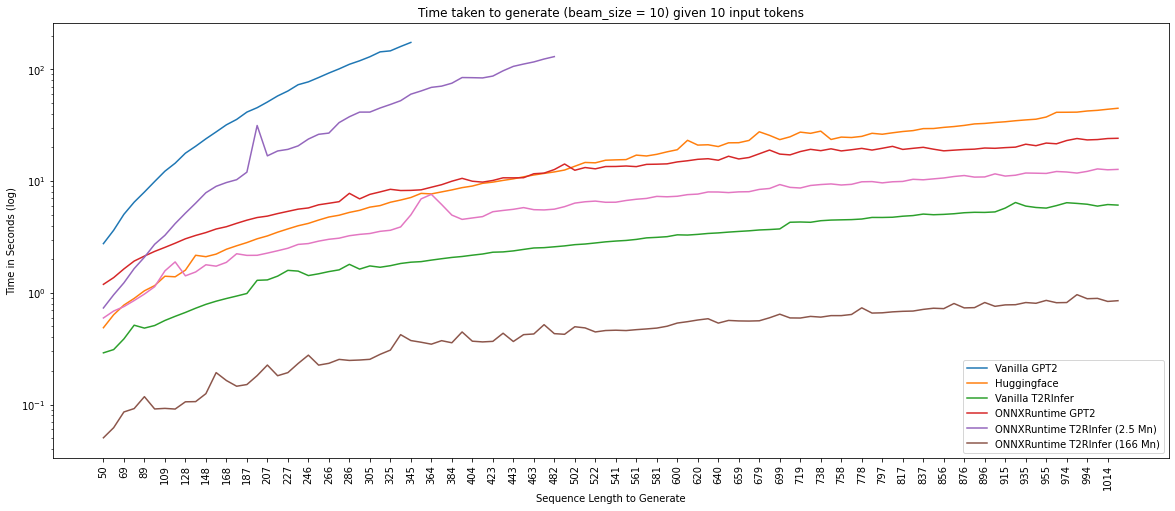

In [7]:
# create plots
plt.figure(figsize = (20, 8))
plt.plot(time_per_seq_vanilla_gpt)
plt.plot(hftime)
plt.plot(trtime)
plt.plot(openvino)
plt.plot(time_per_seq_onnx_gpt)
plt.plot(time_per_seq_onnx_rnn)
plt.plot(rnn_163Mn)
plt.ylabel("Time in Seconds (log)")
plt.xticks(
  ticks = np.arange(len(text_lengths) // 2) * 2,
  labels = np.array(text_lengths)[np.arange(0, len(text_lengths), 2)],
  rotation = 90
)
plt.xlabel("Sequence Length to Generate")
plt.legend([
  "Vanilla GPT2",
  "Huggingface",
  "Vanilla T2RInfer",
  "ONNXRuntime GPT2",
  "ONNXRuntime T2RInfer (2.5 Mn)",
  "ONNXRuntime T2RInfer (166 Mn)"
])
plt.title("Time taken to generate (beam_size = 10) given 10 input tokens")
plt.yscale("log")
plt.savefig("./raw_time_log.png")

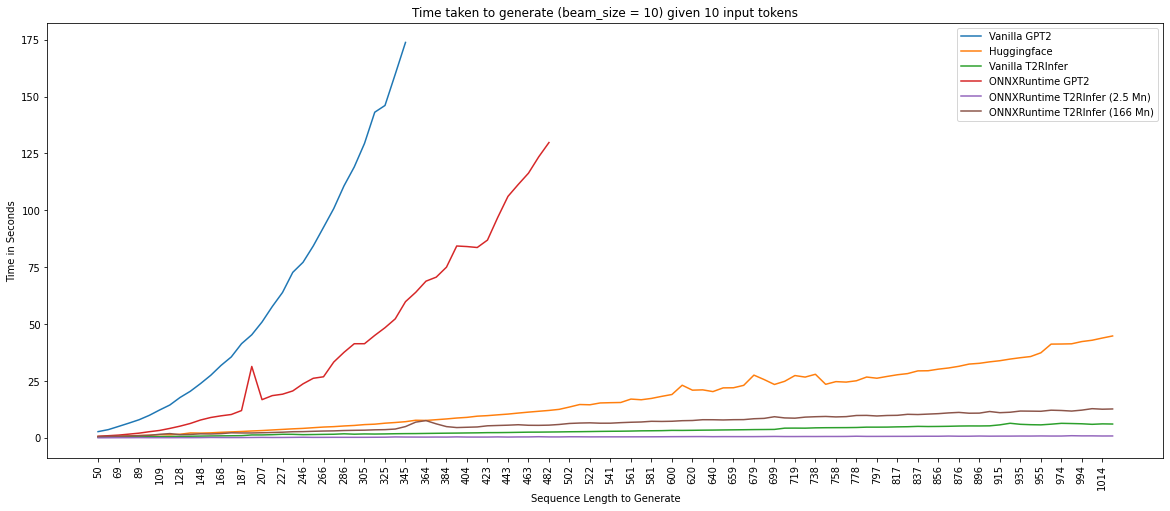

In [291]:
# create plots
plt.figure(figsize = (20, 8))
plt.plot(time_per_seq_vanilla_gpt)
plt.plot(hftime)
plt.plot(trtime)
plt.plot(time_per_seq_onnx_gpt)
plt.plot(time_per_seq_onnx_rnn)
plt.plot(rnn_163Mn)
plt.ylabel("Time in Seconds")
plt.xticks(
  ticks = np.arange(len(text_lengths) // 2) * 2,
  labels = np.array(text_lengths)[np.arange(0, len(text_lengths), 2)],
  rotation = 90
)
plt.xlabel("Sequence Length to Generate")
plt.legend([
  "Vanilla GPT2",
  "Huggingface",
  "Vanilla T2RInfer",
  "ONNXRuntime GPT2",
  "ONNXRuntime T2RInfer (2.5 Mn)",
  "ONNXRuntime T2RInfer (166 Mn)"
])
plt.title("Time taken to generate (beam_size = 10) given 10 input tokens")
plt.savefig("./raw_time.png")